In [54]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import random
import itertools as iter

**Loss Function**

In [55]:
def sel(y, yhat):
    return (yhat - y)**2

**Procedures (Least Squares Method)**

In [56]:
class Least_Square():
    def __init__(self):
        self.params = None
    def fit(self, X, Y):
        if len(X) != len(Y):
            raise ValueError("X and Y must have the same length.")
        #y = mx + c = Ap, where A = [[x, 1]] and p = [[m], [c]]
        A = np.vstack([X, np.ones(len(X))]).T
        self.m, self.c = np.linalg.lstsq(A, Y, rcond=None)[0]
        #return the model object
        return self
    
    def fit_plane(self, X, Y, Z):
        if len(X) != len(Y) or len(Z) != len(Y):
            raise ValueError("X, Y, Z must have the same length.")
        
        # aX + bY + c = Z 
        # AX = B, where A = [[X, Y, 1]] and X = [[a], [b], [c]] and B = Z
        A = np.vstack([X, Y, np.ones(len(X))]).T #transpose to get column vector
        self.a, self.b, self.c = np.linalg.lstsq(A, Z, rcond=None)[0]
        return self
    
    def predict(self, X: np.array):
        prediction =  X * self.m + self.c
        return prediction
    
    def predict_plane(self, X, Y):
        Z = X * self.a + Y * self.b + self.c
        return Z

    

**RANSAC**

In [57]:
class RANSAC():
    def __init__(self,  model, loss_fun, n = 5, k = 500, t = None):
        '''This is the constructor for the ransac object.

        Attribute
        ------------
        model: model object implementing fit and predict
        loss: a loss function to assert model fit
        n : Minimum number of data points to estimate the parameters
        k : maximum iterations allowed
        t : threshold value to determine if point are fit well, if not provided will automatically use percentile
        percentile: percentile of error if want to use value other than 95
        '''

        self.model = model
        self.loss_fun = loss_fun
        self.n = n
        self.t = t
        self.k = k
        self.bestFit = None
        self.x_inliers = []
        self.y_inliers = []
        self.z_inliers = []
        self.mostInlnliers = 0

    #line fit
    def fit(self, X, Y):
        for i in range(self.k):
            randomIDs = np.random.randint(0, len(X), self.n) #get n random IDs
            #sampling random points
            maybeInliersX = X[randomIDs]
            maybeInliersY = Y[randomIDs]

            #fit model
            maybeModel = self.model.fit(maybeInliersX, maybeInliersY)

            #fit remaining points to model
            yhat = maybeModel.predict(X) 
            loss = self.loss_fun(Y, yhat)
            
            #Choose threshold if t is not provided then use 1 mad (median average deviation) as threshold
            #median is better when dealing with outlier than mean
            if self.t ==  None:
                threshold = np.sum(np.abs(loss - np.mean(loss))) / len(loss)
            else: 
                threshold = self.t

            #get the inliers
            inliersX = np.asarray([X[e] for e in range(len(loss)) if loss[e] < threshold])
            inliersY = np.asarray([Y[e] for e in range(len(loss)) if loss[e] < threshold])

            #check if have sufficient inliers
            if len(inliersX) > self.mostInlnliers and len(inliersX) >= self.n:
                #store the inliers
                self.x_inliers = inliersX #inliers
                self.y_inliers = inliersY #inliers
                self.mostInlnliers = len(inliersX)
            #store model
            self.bestFit = self.model.fit(self.x_inliers, self.y_inliers) 
                         
        return self
    
    #plane fit
    def fit_3d(self, X, Y, Z):
        for i in range(self.k):
            randomIDs = random.sample(range(0, len(X)), self.n) #get n random IDs

            #sampling random points
            maybeInliersX = np.asarray([X[e] for e in (randomIDs)])
            maybeInliersY = np.asarray([Y[e] for e in (randomIDs)])
            maybeInliersZ = np.asarray([Z[e] for e in (randomIDs)])

            #fit model
            maybeModel = self.model.fit_plane(maybeInliersY, maybeInliersX, maybeInliersZ)

            #fit remaining points to model
            zhat = maybeModel.predict_plane(X, Y) 
            loss = self.loss_fun(Z, zhat)

            #Choose threshold if t is not provided then use 1 sd from error mean
            if self.t ==  None:
                threshold = np.sum(np.abs(loss - np.median(loss)))/len(loss)
            else:
                threshold = self.t

            #get the inliers
            inliersX = np.asarray([X[e] for e in range(len(loss)) if loss[e] < threshold])
            inliersY = np.asarray([Y[e] for e in range(len(loss)) if loss[e] < threshold])
            inliersZ = np.asarray([Z[e] for e in range(len(loss)) if loss[e] < threshold])

            #check if have sufficient inlier
            if len(inliersX) >= self.mostInlnliers and len(inliersX) >= self.n:
                #store the inliers
                self.x_inliers = inliersX 
                self.y_inliers = inliersY
                self.z_inliers = inliersZ 
                self.mostInlnliers = len(inliersX)
            #store model
            self.bestFit = self.model.fit_plane(self.x_inliers, self.y_inliers, self.z_inliers)
         
        return self


**Demonstration using dummy data**

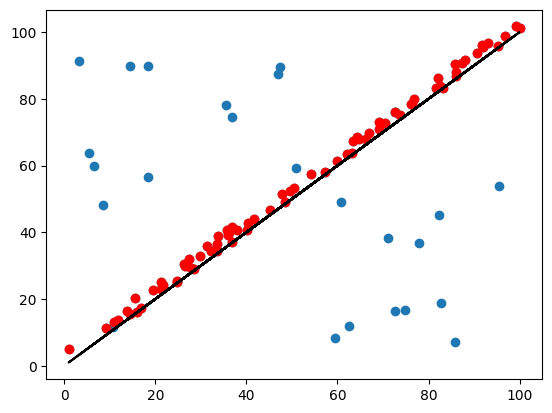

In [58]:
#Dummy data
np.random.seed(707)

#define slope and intercept
slope = 1
intercept = 0

#get the data with the trend
x_ = np.random.uniform(0,100,75) #75 points
y_ = slope * x_ + intercept
noises = np.random.uniform(0, 5, 75)
y_ = y_ + noises
#generate noises
noise_x = np.random.uniform(0, 100, 25)
noise_y = np.random.uniform(0, 100, 25)
x = np.append(x_, noise_x)
y = np.append(y_, noise_y)

fig, data = plt.subplots()
data.plot(x, y,'o') #data points
data.plot(x_, y_, 'ro') #inliers
data.plot(x, slope* x + intercept, 'k-')

RANSAC Fitting


In [59]:
ransac_op = RANSAC(model = Least_Square(), 
                   loss_fun = sel, 
                    k = 1000,
                    n = 2
                    )

In [60]:
ransac_mod = ransac_op.fit(x,y)

In [61]:
ransac_mod.x_inliers.shape

(84,)

Least Squares Fit to compare

In [62]:
lm = Least_Square()
lm.fit(x, y)

**Visualization**

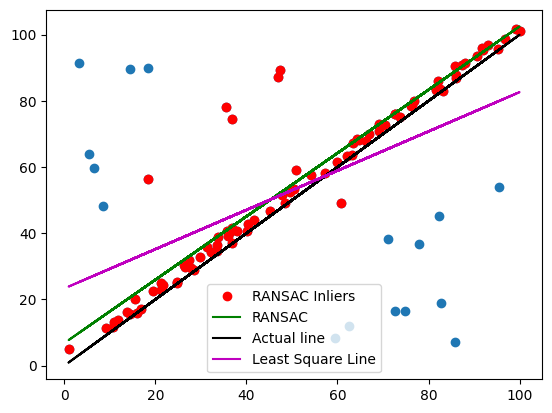

In [63]:
yval = ransac_mod.bestFit.predict(x) #ransac's
y_lm = lm.predict(x) #least squares
plt.scatter(x, y) #all points
plt.plot(ransac_mod.x_inliers, ransac_mod.y_inliers, 'ro', label = 'RANSAC Inliers') #inliers
plt.plot(x, yval, 'g-', label = "RANSAC")
plt.plot(x, slope* x + intercept, 'k-', label = "Actual line")
plt.plot(x, y_lm, 'm-', label = "Least Square Line")
plt.legend()

**3D fitting**

In [64]:
np.random.seed(22)
#setting the trend
a = 1
b = 2
c = 3

#inliers
x_ = np.random.uniform(0, 100, 75)
y_ = np.random.uniform(0, 100, 75)
noises = np.random.uniform(0, 5, 75)
z_ = a * x_ + b * y_ + c + noises

#outliers
x_noises = np.random.uniform(0,100,25)
y_noises = np.random.uniform(0,100,25)
z_noises = np.random.uniform(0,100,25)

#full dataset
x = np.append(x_, x_noises)
y = np.append(y_, y_noises)
z = np.append(z_, z_noises)

#Least square line
lsq = Least_Square()
lsq.fit_plane(x, y, z)
zhat = lsq.predict_plane(x, y)

xx, yy = np.meshgrid(x, y)
zz = lsq.a * xx + lsq.b * yy + lsq.c

xxx, yyy, zzz = np.meshgrid(x, y, z)

#real plane
zreal = a*xx + b*yy + c


Checking the data

In [48]:
x_

array([20.84605374, 48.16810618, 42.05380353, 85.91819985, 17.11615536,
       33.88639606, 27.05328333, 69.10413504, 22.04045166, 81.19509205,
        1.05268743, 56.12036967, 81.37261874, 74.51002961, 18.91113553,
        0.61408663, 77.20438714, 95.78321681, 70.19378841, 29.75782669,
       76.7992742 , 68.82183249, 38.71834804, 61.52058251, 42.75552398,
       58.42896432, 70.26355189, 11.18951719, 92.32699258, 98.88862739,
       67.74107735, 79.51647755,  2.90763493, 17.7759071 , 87.49277453,
       74.49320774, 50.80901632, 12.83339018, 48.42842385, 51.57734878,
       31.12646634,  4.56615426, 43.76806601,  9.58846099,  4.52101119,
       68.48287187, 84.91907452, 12.52071832, 12.90640072, 47.30600021,
       19.75585092, 78.16227488, 60.74138631, 44.35000943, 98.20291086,
       70.89554138, 21.87304154, 16.74882981, 53.87654731, 31.34207882,
       91.15369974,  8.62556798, 31.40740298, 21.91373619, 73.66662295,
       82.85403649, 74.4564463 , 17.75370379, 85.84531959,  0.55

Get Least Squares 

In [65]:
print("z =", lsq.a, "x +", lsq.b, "y +", lsq.c)

z = 0.7373453678058596 x + 1.7321286007863401 y + 4.593681340255226


RANSAC Fitting

In [66]:
ransacc = RANSAC(model = Least_Square(), 
                 loss_fun = sel,
                 n = 3,
                 k = 1000,
                 t = 5
                )

In [67]:
ransacc.fit_3d(x, y, z)

In [68]:
ransacc.z_inliers.shape

(14,)

Check RANSAC's parameters

In [69]:
print("z = ", ransacc.bestFit.a,"X +", ransacc.bestFit.b,"Y +", ransacc.bestFit.c)

z =  0.9394201939247965 X + 1.828894853829984 Y + 11.027610455502142
